In [1]:
import torch
from exp.nb_12 import test_close
torch.seed()

i_h = torch.nn.Embedding(1001, 50)
h_h = torch.nn.Linear(50, 50)
h_o = torch.nn.Linear(50, 1001)
relu = torch.nn.ReLU()

In [2]:
x1, x2, x3 = [1,11,111], [2,12,112], [3,13,113]
h = h_h(i_h(torch.tensor(x1))); print(h.shape)
h = relu(h); print(h.shape)

h = h + i_h(torch.tensor(x2)); print(h.shape)
h = relu(h_h(h))

h = h + i_h(torch.tensor(x3)); print(h.shape)
h = relu(h_h(h))

o1 = h_o(h); print(h.shape)

torch.Size([3, 50])
torch.Size([3, 50])
torch.Size([3, 50])
torch.Size([3, 50])
torch.Size([3, 50])


In [3]:
# refactor
x = torch.tensor([[1,2,3], [11,12,13], [111,112,113]]); print(x[:, 0])
h = relu(h_h(i_h(x[:, 0])))
h = relu(h_h(h + i_h(x[:, 1])))
h = relu(h_h(h + i_h(x[:, 2]))); print(h.shape)
o2 = h_o(h)
test_close(o1, o2)

tensor([  1,  11, 111])
torch.Size([3, 50])


In [4]:
# continue refactor
x = torch.tensor([[1,2,3], [11,12,13], [111,112,113]]); print(x[:, 0]); print(x.shape[1])
h = 0
for i in range(x.shape[1]):
    h = relu(h_h(h + i_h(x[:, i])))
o3 = h_o(h)
test_close(o1, o3)

tensor([  1,  11, 111])
3


In [9]:
o1.shape

torch.Size([3, 1001])

In [5]:
from torch.nn import Module
from torch.functional import F

class LMModel1(Module):
    def __init__(self, vocab_sz, n_hidden):
        super(LMModel1, self).__init__()
        self.i_h = torch.nn.Embedding(vocab_sz, n_hidden)
        self.h_h = torch.nn.Linear(n_hidden, n_hidden)
        self.h_o = torch.nn.Linear(n_hidden, vocab_sz)
    
    def forward(self, x):
        h = 0
        for i in range(3):
            h = h + self.i_h(x[:, i])
            h = F.relu(self.h_h(h))
        return self.h_o(h)

model = LMModel1(vocab_sz=1001, n_hidden=50)
o4 = model(x); print(o4.shape)

torch.Size([3, 1001])


In [6]:
from fastai.data.external import URLs, untar_data

In [7]:
import fastai

In [8]:
path = untar_data(URLs.HUMAN_NUMBERS)
path.ls()

(#2) [Path('/home/vule/.fastai/data/human_numbers/train.txt'),Path('/home/vule/.fastai/data/human_numbers/valid.txt')]

In [9]:
from fastcore.foundation import L
import pandas as pd
from torch import tensor
from fastai.data.core import DataLoaders

# Load data
train_df = pd.read_csv(path/'train.txt', header=None, names=['number'])
valid_df = pd.read_csv(path/'valid.txt', header=None, names=['number'])
data_df = pd.concat([train_df, valid_df])
data_df.number = data_df.number.apply(lambda x: x.strip())


# Convert word to number.
text = ' . '.join(data_df.number.to_list())
tokens = text.split(' ')
vocabs = L(tokens).unique()
word2idx = {w:i for i, w in enumerate(vocabs)}
nums = [word2idx[w] for w in tokens]

In [10]:
len(vocabs)

30

In [11]:
# L([(tokens[i:i+3], tokens[i+3]) for i in range(0, len(tokens)-4, 3)])
seqs = L([(tensor(nums[i:i+3]), nums[i+3]) for i in range(0, len(nums)-4, 3)])

bs = 64
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(seqs[:cut], seqs[cut:], bs=bs, shuffle=False)

In [12]:
dls.train_ds; dls.valid_ds

(#4207) [(tensor([ 1,  8, 29]), 26),(tensor([26,  5,  1]), 8),(tensor([ 8, 29, 26]), 6),(tensor([6, 1, 8]), 29),(tensor([29, 26,  7]), 1),(tensor([ 1,  8, 29]), 26),(tensor([26,  8,  1]), 8),(tensor([ 8, 29, 26]), 9),(tensor([9, 1, 8]), 29),(tensor([29, 27,  1]), 8)...]

In [13]:
b = dls.one_batch()
b[0].shape, b[1].shape

(torch.Size([64, 3]), torch.Size([64]))

In [14]:
from fastai.learner import Learner
from fastai.callback.all import *
from torch.functional import F
from fastai.metrics import accuracy

In [15]:
learn = Learner(dls, LMModel1(len(vocabs), n_hidden=64), loss_func=F.cross_entropy, metrics=accuracy)

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.12022644281387329)

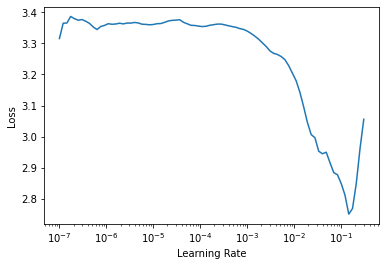

In [16]:
learn.lr_find()

In [17]:
learn.fit_one_cycle(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.313570,2.111984,0.487521,00:01
1,1.265121,1.946874,0.481341,00:03
2,1.334385,1.535688,0.449964,00:01
3,1.343860,1.562397,0.501070,00:01


In [18]:
# we only get accuracy about 35% if we shuffle data.
# when samples are not iid. The order matter.

In [19]:
# instead intial hidden value from zeros, we let it learn from data.

In [20]:
from torch.autograd import Variable

class LMModel2(Module):
    def __init__(self, vocab_sz, n_hidden):
        super(LMModel2, self).__init__()
        self.i_h = torch.nn.Embedding(vocab_sz, n_hidden)
        self.h_h = torch.nn.Linear(n_hidden, n_hidden)
        self.h_o = torch.nn.Linear(n_hidden, vocab_sz)
        self.inital_h = Variable(torch.rand(1, n_hidden), requires_grad=True)
    def forward(self, x):
        h = self.inital_h
        for i in range(3):
            h = h + self.i_h(x[:, i])
            h = F.relu(self.h_h(h))
        return self.h_o(h)

model2 = LMModel2(vocab_sz=len(vocabs), n_hidden=64)
o4 = model2(b[0]); print(o4.shape)

torch.Size([64, 30])


In [21]:
learn = Learner(dls, model2, loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(8, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.513237,2.174897,0.485619,00:02
1,1.213942,2.012939,0.497742,00:02
2,1.236195,2.687970,0.430711,00:02
3,1.237812,2.484218,0.496553,00:01
4,1.360928,2.013160,0.408367,00:01
5,1.314140,1.695347,0.507012,00:01
6,1.283506,1.707710,0.507012,00:02
7,1.271556,1.669346,0.394105,00:01


In [22]:
# extend input length from 3 to 4
# L([(tokens[i:i+3], tokens[i+3]) for i in range(0, len(tokens)-4, 3)])
seqs = L([(tensor(nums[i:i+4]), nums[i+4]) for i in range(0, len(nums)-5, 3)])

bs = 64
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(seqs[:cut], seqs[cut:], bs=bs, shuffle=False)

class LMModel3(Module):
    def __init__(self, vocab_sz, n_hidden):
        super(LMModel3, self).__init__()
        self.i_h = torch.nn.Embedding(vocab_sz, n_hidden)
        self.h_h = torch.nn.Linear(n_hidden, n_hidden)
        self.h_o = torch.nn.Linear(n_hidden, vocab_sz)
        self.inital_h = Variable(torch.rand(1, n_hidden), requires_grad=True)
    def forward(self, x):
        h = self.inital_h
        for i in range(4):
            h = h + self.i_h(x[:, i])
            h = F.relu(self.h_h(h))
        return self.h_o(h)

model3 = LMModel3(vocab_sz=len(vocabs), n_hidden=64)

learn = Learner(dls, model3, loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(8, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.433463,2.243866,0.424631,00:01
1,1.415526,2.031033,0.480266,00:01
2,1.356055,1.907913,0.485021,00:01
3,1.328258,1.774331,0.492867,00:01
4,1.309693,1.704420,0.496196,00:01
5,1.314583,1.646431,0.502378,00:01
6,1.308275,1.613481,0.501902,00:01
7,1.284941,1.634750,0.457680,00:01


In [23]:
i = 0
[0,1,2,3,4,5][i+3:i+5]

[3, 4]

In [24]:
# save all hidden states instead of the last one. using it to calculate loss.
# L([(tokens[i:i+3], tokens[i+1:i+4]) for i in range(0, len(tokens)-4, 3)])
seqs = L([(tensor(nums[i:i+4]), tensor(nums[i+3:i+5])) for i in range(0, len(nums)-5, 3)])
bs = 64
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(seqs[:cut], seqs[cut:], bs=bs, shuffle=False)
X , y = dls.one_batch()
X.shape, y.shape

(torch.Size([64, 4]), torch.Size([64, 2]))

In [25]:
from torch.autograd import Variable

class LMModel3(Module):
    def __init__(self, vocab_sz, n_hidden):
        super(LMModel3, self).__init__()
        self.i_h = torch.nn.Embedding(vocab_sz, n_hidden)
        self.h_h = torch.nn.Linear(n_hidden, n_hidden)
        self.h_o = torch.nn.Linear(n_hidden, vocab_sz)
        self.inital_h = Variable(torch.rand(1, n_hidden), requires_grad=True)

    def forward(self, x):
        h = self.inital_h
        outs = []
        for i in range(4):
            h = h + self.i_h(x[:, i])
            h = F.relu(self.h_h(h))
            if i>=2: outs.append(self.h_o(h))
        return torch.stack(outs, dim=1)

model3 = LMModel3(vocab_sz=len(vocabs), n_hidden=64)
o4 = model3(X); print(o4.shape)

torch.Size([64, 2, 30])


In [26]:
def loss_function(inp, targ):
    return F.cross_entropy(inp.view(-1, len(vocabs)), targ.view(-1))

In [27]:
loss_function(o4, y)

tensor(3.4377, grad_fn=<NllLossBackward>)

In [28]:
learn = Learner(dls, model3, loss_func=loss_function, metrics=accuracy)
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.493052,1.989056,0.477294,00:02
1,1.323665,1.834136,0.454351,00:05
2,1.352542,1.581849,0.483952,00:02
3,1.444858,1.612293,0.426058,00:02


In [29]:
# Using the last state of the previous batch as the inital state of next batch.

In [30]:
seqs = L([(tensor(nums[i:i+3]), nums[i+3]) for i in range(0, len(nums)-4, 3)])
bs = 64
m = len(seqs) // 64
# reorder seqs to reuse the last state
print(seqs[0], seqs[m-1])
print(seqs[m], seqs[2*m-1])

def group_chucks(ds, bs):
    m = len(ds) // bs
    reorder_seqs = L()
    for m_i in range(m): reorder_seqs += [seqs[bs_i*m + m_i] for bs_i in range(bs)]
    return reorder_seqs

dls = DataLoaders.from_dsets(group_chucks(seqs[:cut], bs), group_chucks(seqs[cut:], bs), bs=bs, shuffle=False, drop_last=True)
# X, y = dls.one_batch()

(tensor([0, 1, 2]), 1) (tensor([ 2, 28, 23]), 3)
(tensor([3, 1, 2]), 28) (tensor([0, 1, 4]), 28)


In [31]:
from torch.autograd import Variable

class LMModel4(Module):
    def __init__(self, vocab_sz, n_hidden):
        super(LMModel4, self).__init__()
        self.i_h = torch.nn.Embedding(vocab_sz, n_hidden)
        self.h_h = torch.nn.Linear(n_hidden, n_hidden)
        self.h_o = torch.nn.Linear(n_hidden, vocab_sz)
        self.inital_h = Variable(torch.rand(1, n_hidden), requires_grad=True)

    def forward(self, x):
        for i in range(3):
            self.h = self.h + self.i_h(x[:, i])
            self.h = F.relu(self.h_h(self.h))
        out = self.h_o(self.h)
        self.h = self.h.detach()
        return out
    
    def reset(self): self.h = 0
        
model4 = LMModel4(vocab_sz=len(vocabs), n_hidden=64)
model4.reset()
o4 = model4(X); print(o4.shape)

torch.Size([64, 30])


In [32]:
learn = Learner(dls, model4, loss_func=F.cross_entropy, metrics=accuracy, cbs=[ModelResetter])

# learn.lr_find()

learn.fit_one_cycle(10, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.734186,1.784795,0.414423,00:01
1,1.287117,1.495087,0.464904,00:01
2,1.078313,1.379143,0.517067,00:01
3,1.016521,1.218339,0.549279,00:01
4,0.957809,1.102992,0.588221,00:01
5,0.899413,0.990202,0.604808,00:01
6,0.855093,0.940884,0.618510,00:01
7,0.818563,0.902781,0.636779,00:01
8,0.772911,0.874325,0.661779,00:01
9,0.755985,0.853539,0.661058,00:01


In [44]:
# creating more signal:
ls = 16
seqs = L([(tensor(nums[i:i+ls]), tensor(nums[i+1:i+1+ls])) for i in range(0, len(nums)-ls-1, ls)])
cut = int(len(seqs) * 0.80)
bs = 64
m = len(seqs) // 64
# reorder seqs to reuse the last state
print(seqs[0], seqs[m-1])
print(seqs[m], seqs[2*m-1])

def group_chucks(ds, bs):
    m = len(ds) // bs
    reorder_seqs = L()
    for m_i in range(m): reorder_seqs += [seqs[bs_i*m + m_i] for bs_i in range(bs)]
    return reorder_seqs

dls = DataLoaders.from_dsets(group_chucks(seqs[:cut], bs), group_chucks(seqs[cut:], bs), bs=bs, shuffle=False, drop_last=True)
X, y = dls.one_batch()

(tensor([0, 1, 2, 1, 3, 1, 4, 1, 5, 1, 6, 1, 7, 1, 8, 1]), tensor([1, 2, 1, 3, 1, 4, 1, 5, 1, 6, 1, 7, 1, 8, 1, 9])) (tensor([ 8,  1,  2, 28, 22,  9,  1,  2, 28, 23,  1,  2, 28, 23,  0,  1]), tensor([ 1,  2, 28, 22,  9,  1,  2, 28, 23,  1,  2, 28, 23,  0,  1,  2]))
(tensor([ 2, 28, 23,  2,  1,  2, 28, 23,  3,  1,  2, 28, 23,  4,  1,  2]), tensor([28, 23,  2,  1,  2, 28, 23,  3,  1,  2, 28, 23,  4,  1,  2, 28])) (tensor([ 5,  1,  4, 28, 23,  6,  1,  4, 28, 23,  7,  1,  4, 28, 23,  8]), tensor([ 1,  4, 28, 23,  6,  1,  4, 28, 23,  7,  1,  4, 28, 23,  8,  1]))


In [45]:
from torch.autograd import Variable

class LMModel5(Module):
    def __init__(self, vocab_sz, n_hidden):
        super(LMModel5, self).__init__()
        self.i_h = torch.nn.Embedding(vocab_sz, n_hidden)
        self.h_h = torch.nn.Linear(n_hidden, n_hidden)
        self.h_o = torch.nn.Linear(n_hidden, vocab_sz)
        self.h = 0
    def forward(self, x):
        outs = []
        for i in range(ls):
            self.h = self.h + self.i_h(x[:, i])
            self.h = F.relu(self.h_h(self.h))
            outs.append(self.h_o(self.h))
        self.h = self.h.detach()
        return torch.stack(outs, dim=1)
    
    def reset(self): self.h = 0


model5 = LMModel5(vocab_sz=len(vocabs), n_hidden=64)
model5.reset()
o4 = model5(X); print(o4.shape)

torch.Size([64, 16, 30])


In [46]:
learn = Learner(dls, model5, loss_func=loss_function, metrics=accuracy, cbs=[ModelResetter])

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.010964781977236271)

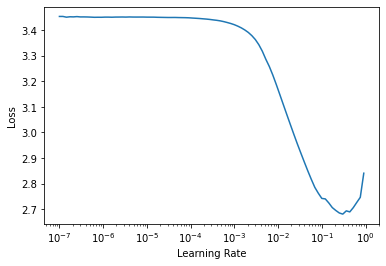

In [47]:
learn.lr_find()

In [48]:
learn.fit_one_cycle(15, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.241925,2.978011,0.253337,00:00
1,2.288593,1.789420,0.397217,00:00
2,1.723006,1.516585,0.475749,00:00
3,1.436987,1.411505,0.509766,00:00
4,1.284275,1.315724,0.537842,00:00
5,1.151206,1.209869,0.573730,00:00
6,1.038243,1.152799,0.583252,00:00
7,0.956245,1.065239,0.628255,00:00
8,0.885087,1.009890,0.655843,00:00
9,0.838413,0.998199,0.656250,00:00
